## torch.nn

we're going to start using torch's nn classes for our model 

this will clean the code up allow us to track more training runs

we'll also start breaking up our data in train/dev/test splits to ensure we're not overfitting on the training data

### standard setup

In [213]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import collections

In [262]:
%run ../lib/basic_sampling.py

In [263]:
names = NameSampling("../resources/names.txt")

vocab_size = len(names.itos)
vocab_size

27

In [216]:
train = names.train

### Neural net lib

use an orderedDict so we can reference the layers 

we'll experiment with xavier_uniform_ initialization (kaiming documentation recommend only relu or leaky relu?

the Sequential class will run input successively through each layer

the layers automatically set grad to true and the Sequential module tracks our parameters

In [217]:
class SimpleNames(nn.Module):

    def __init__(self, embedding_size = 6, hidden_size = 100, context_length = 5, vocab_size = 27):
        super().__init__()

        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.context_length = context_length
        
        layer_dict = collections.OrderedDict([
            ('embed', nn.Embedding(vocab_size, embedding_size)),
            ('flatten', nn.Flatten(1)),
            ('feed_forward', nn.Linear(embedding_size*context_length, hidden_size, bias=True)),
            ('non_linearity', nn.Tanh()),
            ('logits', nn.Linear(hidden_size, vocab_size, bias=True)),
        ])

        nn.init.xavier_uniform_(layer_dict['feed_forward'].weight, gain=5/3)
        nn.init.zeros_(layer_dict['feed_forward'].bias)
        
        nn.init.zeros_(layer_dict['logits'].bias)

        self.model = nn.Sequential(
            layer_dict
        )
        self.layer_dict = layer_dict

    def forward(self, idx, targets=None):
        logits = self.model(idx)
    
        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    #TODO update this if context length changes
    def generate(self, num_names):
        new_names = []
        for i in range(num_names):
            out = []
            ix = [[0, 0, 0, 0, 0]]
            for nl in range(10):
                logits = self.model(torch.tensor(ix))

                p = F.softmax(logits, dim=1)
        
                prediction = torch.multinomial(p, num_samples=1).item()
    
                ix = [[ix[0][1], ix[0][2], ix[0][3], ix[0][4], prediction]]
    
                if prediction == 0:
                    break
                out.append(names.itos[prediction])
                
            new_names.append("".join(out))

        return new_names

### xavier initialization

quite a different profile for the xavier distribution, lets see how it goes

In [6]:
import matplotlib.pyplot as plt

In [7]:
sn = SimpleNames()

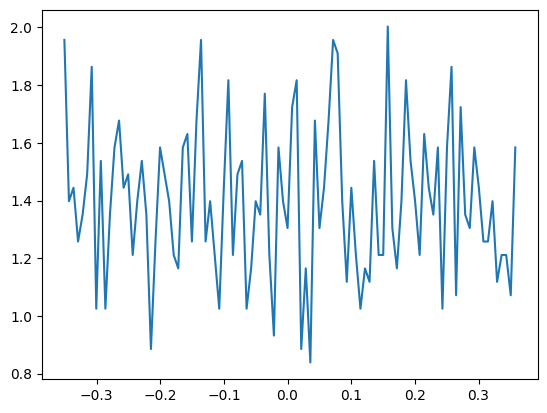

In [8]:
hy, hx = torch.histogram(sn.layer_dict['feed_forward'].weight, density=True)
plt.plot(hx.detach()[1:], hy.detach())

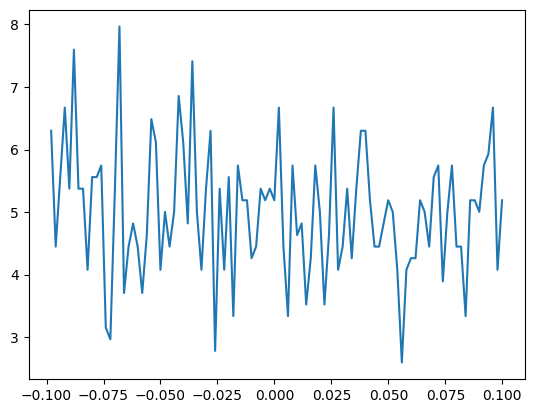

In [9]:
hy, hx = torch.histogram(sn.layer_dict['logits'].weight, density=True)
plt.plot(hx.detach()[1:], hy.detach())

### Parameter sizes for different models

we can now easily see how changing dimensions or hidden layer size can affect parameter count

In [10]:
model = SimpleNames(3)

parameters = model.parameters()
print(model.embedding_size, model.hidden_size, model.context_length, sum(p.nelement() for p in parameters)) # number of parameters in total

model = SimpleNames(6)

parameters = model.parameters()
print(model.embedding_size, model.hidden_size, model.context_length, sum(p.nelement() for p in parameters)) # number of parameters in total

model = SimpleNames(9)

parameters = model.parameters()
print(model.embedding_size, model.hidden_size, model.context_length, sum(p.nelement() for p in parameters)) # number of parameters in total

model = SimpleNames(6, 160)

parameters = model.parameters()
print(model.embedding_size, model.hidden_size, model.context_length, sum(p.nelement() for p in parameters)) # number of parameters in total

model = SimpleNames(9, 160)

parameters = model.parameters()
print(model.embedding_size, model.hidden_size, model.context_length, sum(p.nelement() for p in parameters)) # number of parameters in total

3 100 5 4408
6 100 5 5989
9 100 5 7570
6 160 5 9469
9 160 5 11950


In [267]:
class TestRig:

    def __init__(self, embedding_size, hidden_size, context_length=5, learning_rate = .2):
        self.model = SimpleNames(embedding_size, hidden_size)
        self.context_length = context_length

        parameters = self.model.parameters()
        print(model.embedding_size, model.hidden_size, model.context_length, sum(p.nelement() for p in parameters)) # number of parameters in total
        
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, momentum=0.9)
        self.scheduler = optim.lr_scheduler.MultiplicativeLR(self.optimizer, lr_lambda=lmbda)
        
        self.track = {'gradients': [], 'loss': [], 'learning_rate': []}

    def train(self, epochs, batch_size, content_length):
        for ep in range(epochs):
            epoch_loss = 0
            for s in range(samples):
                x, y = names.get_xys(names.sample_names(batch_size, train))
                X = torch.tensor(x)
                Y = torch.tensor(y)
        
                logits, loss = self.model.forward(X, Y)
        
                epoch_loss += loss.detach()
                self.model.zero_grad(set_to_none=True)
                loss.backward()
                self.optimizer.step()
        
            self.scheduler.step()
        
            if ep % 10 == 0:
                self.track['loss'].append(epoch_loss)
                self.track['learning_rate'].append(self.scheduler.get_last_lr())
                print("learning rate", ep, self.scheduler.get_last_lr())
                print("running loss", epoch_loss/samples)

    @torch.no_grad()
    def val_split(self, x, y):
    
        sample_len = len(x) // 100
        
        val_loss = 0
        for s in range(sample_len):
            X = torch.tensor(x)
            Y = torch.tensor(y)
    
            logits, loss = self.model.forward(X, Y)
        
            val_loss += loss
    
        return val_loss / sample_len

    @torch.no_grad()
    def validate(self, split):
        val_loss = 0
        ws = 0
        for w in split:
            xs = []
            ys = []
            for i in range(len(w)-self.context_length):
                xs.append(w[i:i+self.context_length])
                ys.append(w[i+self.context_length])
            
            X = torch.tensor(xs)
            Y = torch.tensor(ys)
    
            logits, loss = self.model.forward(X, Y)
        
            val_loss += loss
            ws += 1
        return val_loss / ws

In [268]:
# lets see it run first
epochs = 30
batch_size = 20
samples = 200

lmbda = lambda epoch: 0.98

In [269]:
tr = TestRig(3, 60)

9 160 5 2688


In [270]:
tr.train(epochs, batch_size, samples)

learning rate 0 [0.196]
running loss tensor(2.5366)
learning rate 10 [0.16014627014995916]
running loss tensor(2.2976)
learning rate 20 [0.13085116246399847]
running loss tensor(2.2533)


In [243]:
x, y = names.get_xys(names.dev)
print(tr.val_split(x, y))
x, y = names.get_xys(names.test)
print(tr.val_split(x, y))

tensor(2.2340)
tensor(2.2511)


In [16]:
tr.model.generate(10)

['bivden',
 'aniha',
 'emrin',
 'avan',
 'erlio',
 'sylol',
 'chaid',
 'amelyn',
 'kafan',
 'haylew']

In [219]:
# now keep these values for a few runs
epochs = 80
batch_size = 60
samples = 400

In [18]:
tr = TestRig(3, 90)
tr.train(epochs, batch_size, samples)
x, y = names.get_xys(names.dev)
print(tr.val_split(x, y))
x, y = names.get_xys(names.test)
print(tr.val_split(x, y))
tr.model.generate(10)

9 160 5 3978
learning rate 0 [0.196]
running loss tensor(2.4268)
learning rate 10 [0.16014627014995916]
running loss tensor(2.1865)
learning rate 20 [0.13085116246399847]
running loss tensor(2.1550)
learning rate 30 [0.10691492659895763]
running loss tensor(2.1381)
learning rate 40 [0.08735727917438633]
running loss tensor(2.1319)
learning rate 50 [0.07137725729707488]
running loss tensor(2.1248)
learning rate 60 [0.058320415967655595]
running loss tensor(2.1114)
learning rate 70 [0.047652025973541665]
running loss tensor(2.1116)
tensor(2.1324)
tensor(2.1500)


['areli',
 'minnleira',
 'evenyk',
 'mayem',
 'amajanne',
 'norianne',
 'aaphen',
 'borio',
 'nvine',
 'krishliya']

In [19]:
tr = TestRig(6, 120)
tr.train(epochs, batch_size, samples)
x, y = names.get_xys(names.dev)
print(tr.val_split(x, y))
x, y = names.get_xys(names.test)
print(tr.val_split(x, y))
tr.model.generate(10)

9 160 5 7149
learning rate 0 [0.196]
running loss tensor(2.3780)
learning rate 10 [0.16014627014995916]
running loss tensor(2.1197)
learning rate 20 [0.13085116246399847]
running loss tensor(2.0911)
learning rate 30 [0.10691492659895763]
running loss tensor(2.0743)
learning rate 40 [0.08735727917438633]
running loss tensor(2.0564)
learning rate 50 [0.07137725729707488]
running loss tensor(2.0460)
learning rate 60 [0.058320415967655595]
running loss tensor(2.0408)
learning rate 70 [0.047652025973541665]
running loss tensor(2.0326)
tensor(2.0890)
tensor(2.1024)


['mally',
 'yevak',
 'jakea',
 'lyrose',
 'ava',
 'syrone',
 'mackyr',
 'lucio',
 'amareen',
 'roeleigh']

In [20]:
tr = TestRig(9, 120)
tr.train(epochs, batch_size, samples)
x, y = names.get_xys(names.dev)
print(tr.val_split(x, y))
x, y = names.get_xys(names.test)
print(tr.val_split(x, y))
tr.model.generate(10)

9 160 5 9030
learning rate 0 [0.196]
running loss tensor(2.3360)
learning rate 10 [0.16014627014995916]
running loss tensor(2.0977)
learning rate 20 [0.13085116246399847]
running loss tensor(2.0604)
learning rate 30 [0.10691492659895763]
running loss tensor(2.0406)
learning rate 40 [0.08735727917438633]
running loss tensor(2.0258)
learning rate 50 [0.07137725729707488]
running loss tensor(2.0163)
learning rate 60 [0.058320415967655595]
running loss tensor(2.0061)
learning rate 70 [0.047652025973541665]
running loss tensor(1.9945)
tensor(2.0822)
tensor(2.0923)


['brukaviah',
 'yan',
 'kaelapel',
 'alali',
 'omisdiel',
 'maylan',
 'jackella',
 'abiko',
 'kamdyn',
 'haleem']

In [272]:
# now keep these values for a few runs
epochs = 140
batch_size = 60
samples = 2000

In [273]:
tr = TestRig(12, 120)
tr.train(epochs, batch_size, samples)
x, y = names.get_xys(names.dev)
print(tr.val_split(x, y))
x, y = names.get_xys(names.test)
print(tr.val_split(x, y))
tr.model.generate(10)

9 160 5 10911
learning rate 0 [0.196]
running loss tensor(2.1997)
learning rate 10 [0.16014627014995916]
running loss tensor(2.0348)
learning rate 20 [0.13085116246399847]
running loss tensor(2.0085)
learning rate 30 [0.10691492659895763]
running loss tensor(1.9883)
learning rate 40 [0.08735727917438633]
running loss tensor(1.9725)
learning rate 50 [0.07137725729707488]
running loss tensor(1.9616)
learning rate 60 [0.058320415967655595]
running loss tensor(1.9496)
learning rate 70 [0.047652025973541665]
running loss tensor(1.9377)
learning rate 80 [0.03893517461607997]
running loss tensor(1.9314)
learning rate 90 [0.03181287241021722]
running loss tensor(1.9244)
learning rate 100 [0.025993432955371577]
running loss tensor(1.9199)
learning rate 110 [0.021238527225488715]
running loss tensor(1.9153)
learning rate 120 [0.017353423054287647]
running loss tensor(1.9135)
learning rate 130 [0.014179010084073873]
running loss tensor(1.9105)
tensor(1.9371)
tensor(1.9495)


['colbi',
 'tyrey',
 'yesja',
 'vidian',
 'caigitah',
 'danilah',
 'alika',
 'caralinelu',
 'wefron',
 'blaine']

In [264]:
eval_data = names.create_eval_data()

In [275]:
tr.validate(eval_data)

tensor(1.9786)